In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Log time
import time
start_time = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting
import seaborn as sns; sns.set() # for plotting 
from IPython.display import display
import warnings
warnings.filterwarnings("ignore") # To ignore warning messages while executing the code.

import tqdm
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# SK-learn libraries for evaluation.
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# NLP libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy

# Deep Learning frameworks
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model



MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.


['.config', 'sample_data']


Using TensorFlow backend.


In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')



#DRIVE_PATH = "/content/drive/My Drive/Jigsaw/BERT_data"
DRIVE_PATH = "/content/drive/My Drive/Jigsaw/BERT_data"

print(os.listdir(DRIVE_PATH))


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
['data_boolean_idharm.csv', 'full_train_df.csv', 'full_validate_df.csv', 'full_test_df.csv', 'identity_train_data.csv', 'identity_val_data.csv', 'noidentity_train_data.csv', 'noidentity_val_data.csv', 'unbiased_tokenizer.p', 'biased_tokenizer.p', 'test_df_model1.csv', 'Model2_bias_metrics_df_Results.csv', 'Model2_test_df_Results.csv', 'Model1_bias_metrics_df_Results (1).csv', 'Model1_test_df_Results.csv']


In [14]:
data = pd.read_csv("/content/drive/My Drive/Jigsaw/BERT_data/Model1_test_df_Results.csv")
data_unbiased = pd.read_csv("/content/drive/My Drive/Jigsaw/BERT_data/Model2_test_df_Results.csv")

print("Size of model1 test data = " + str(data.shape[0]))
print("Size of model2 test data = " + str(data_unbiased.shape[0]))

Size of model1 test data = 360975
Size of model2 test data = 360975


In [0]:
# data_unbiased = data_unbiased.sample(n=100000, random_state=91)
# data_unbiased.shape[0]

## Calculating Metrics

In [0]:
# From baseline kernel

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]>0.5
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)



SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]>0.5]
    return compute_auc((subgroup_examples[label]>0.5), subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[(df[subgroup]>0.5) & (df[label]<=0.5)]
    non_subgroup_positive_examples = df[(df[subgroup]<=0.5) & (df[label]>0.5)]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label]>0.5, examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[(df[subgroup]>0.5) & (df[label]>0.5)]
    non_subgroup_negative_examples = df[(df[subgroup]<=0.5) & (df[label]<=0.5)]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label]>0.5, examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]>0.5])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [0]:
def plot_histogram(non_toxic_scores, toxic_scores, description):
  NUM_BINS=10
  sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
  ax = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
  ax.set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[], title='AUC ' + description)
  plt.legend()
  plt.figure()

# Plot toxicity distributions of different identities to visualize bias.
def plot_histogram_for_identity(df, identity):
  toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
  non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]
  plot_histogram(non_toxic_scores, toxic_scores, 'labeled for ' + identity)

def plot_background_histogram(df):
  toxic_scores = df.query('target == True')[MODEL_NAME]
  non_toxic_scores = df.query('target == False')[MODEL_NAME]
  plot_histogram(non_toxic_scores, toxic_scores, 'for all test data')

  


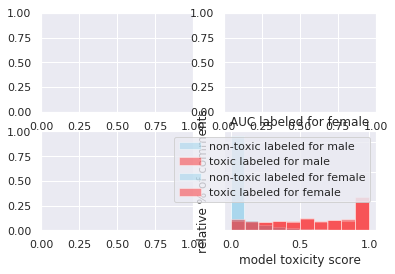

<Figure size 432x288 with 0 Axes>

In [18]:
def plot_hist_subplot_4(df, identities, MODEL_NAME):
  NUM_BINS=10
#  f, axarr = plt.subplots(2, 2)
 # quadrilats = [(0,0), (1,0), (0,1), (1,1)]


#   identity = identities[0]
#   toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
#   non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]

#   description = 'labeled for ' + identity
#   axarr[0,0] = sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
#   axarr[0,0] = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
#   axarr[0,0].set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[], title='AUC ' + description)
  
  
#   identity = identities[1]
#   toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
#   non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]

#   description = 'labeled for ' + identity
#   axarr[1,0] = sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
#   axarr[1,0] = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
#   axarr[1,0].set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[], title='AUC ' + description)
  
#   identity = identities[2]
#   toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
#   non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]

#   description = 'labeled for ' + identity
#   axarr[0,1] = sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
#   axarr[0,1] = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
#   axarr[0,1].set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[], title='AUC ' + description)
  
#   identity = identities[3]
#   toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
#   non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]

#   description = 'labeled for ' + identity
#   axarr[1,1] = sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
#   axarr[1,1] = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
#   axarr[1,1].set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[], title='AUC ' + description)
  
  
  fig, ax = plt.subplots(nrows=2, ncols=2)
  
  identity = identities[0]
  toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
  non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]

  description = 'labeled for ' + identity
  
  ax[0][0] = sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
  ax[0][0] = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
  ax[0][0].set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[], title='AUC ' + description)
  
  
  identity = identities[1]
  toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
  non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]

  description = 'labeled for ' + identity
  ax[1][0] = sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
  ax[1][0] = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
  ax[1][0].set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[], title='AUC ' + description)
  
  
  
  plt.legend()
  plt.figure()

plot_hist_subplot_4(data, ['male','female', 'black', 'white'], 'Model1')

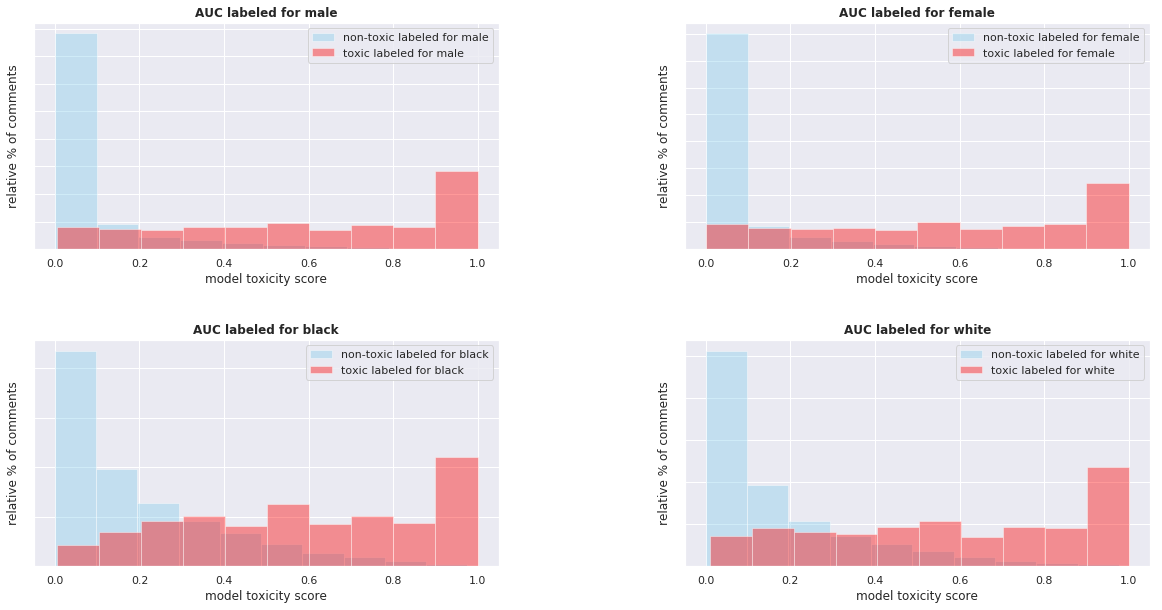

<Figure size 432x288 with 0 Axes>

In [19]:
def plot_hist_subplot_4(df, identities, MODEL_NAME):
  NUM_BINS=10     
  fig = plt.figure(figsize=(20,10))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  
  for i in range(1,5):     
      identity = identities[i-1]      
      toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
      non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]
      description = 'labeled for ' + identity
      
      ax = fig.add_subplot(2, 2, i)  
      sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False, ax=ax)
      sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False, ax=ax)
      ax.set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[]) 
      ax.set_title(label='AUC ' + description, fontweight="bold")
      plt.legend()
  plt.figure()

plot_hist_subplot_4(data, ['male','female', 'black', 'white'], 'Model1')

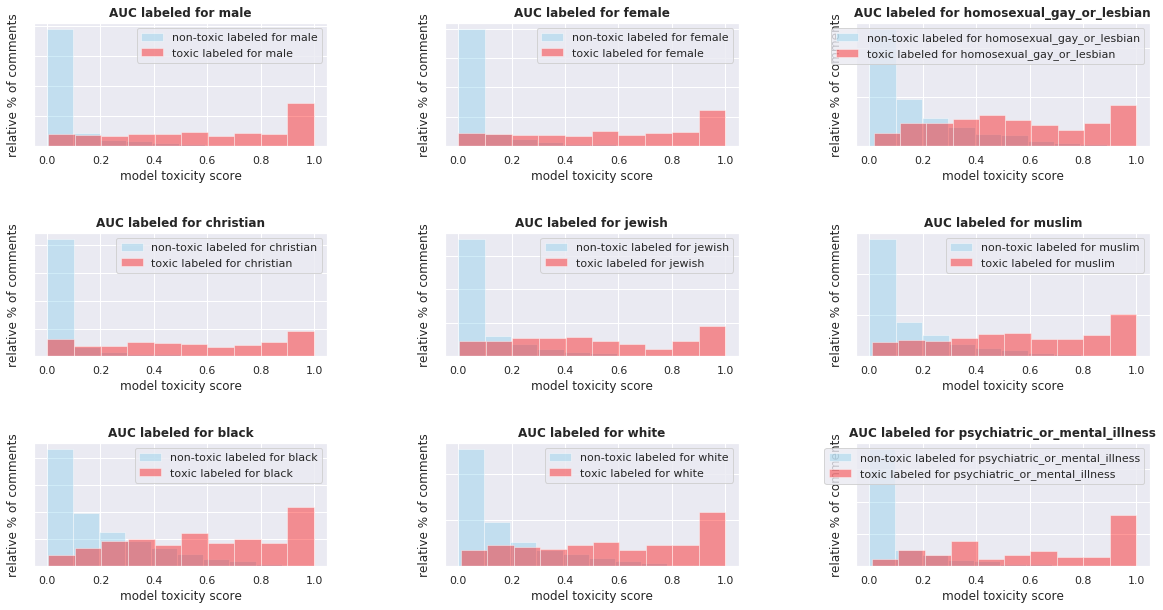

<Figure size 432x288 with 0 Axes>

In [20]:
def plot_hist_subplot_9(df, identities, MODEL_NAME):
  NUM_BINS=10     
  fig = plt.figure(figsize=(20,10))
  fig.subplots_adjust(hspace=0.7, wspace=0.4)
  
  for i in range(1,10):     
      identity = identities[i-1]      
      toxic_scores = df.query(identity + ' == True & target == True')[MODEL_NAME]
      non_toxic_scores = df.query(identity + ' == True & target == False')[MODEL_NAME]
      description = 'labeled for ' + identity
      
      ax = fig.add_subplot(3, 3, i)  
      sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False, ax=ax)
      sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False, ax=ax)
      ax.set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[])  
      ax.set_title(label='AUC ' + description, fontweight="bold")
      plt.legend()
      
  plt.figure()

plot_hist_subplot_9(data, [ 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness'], 'Model1')

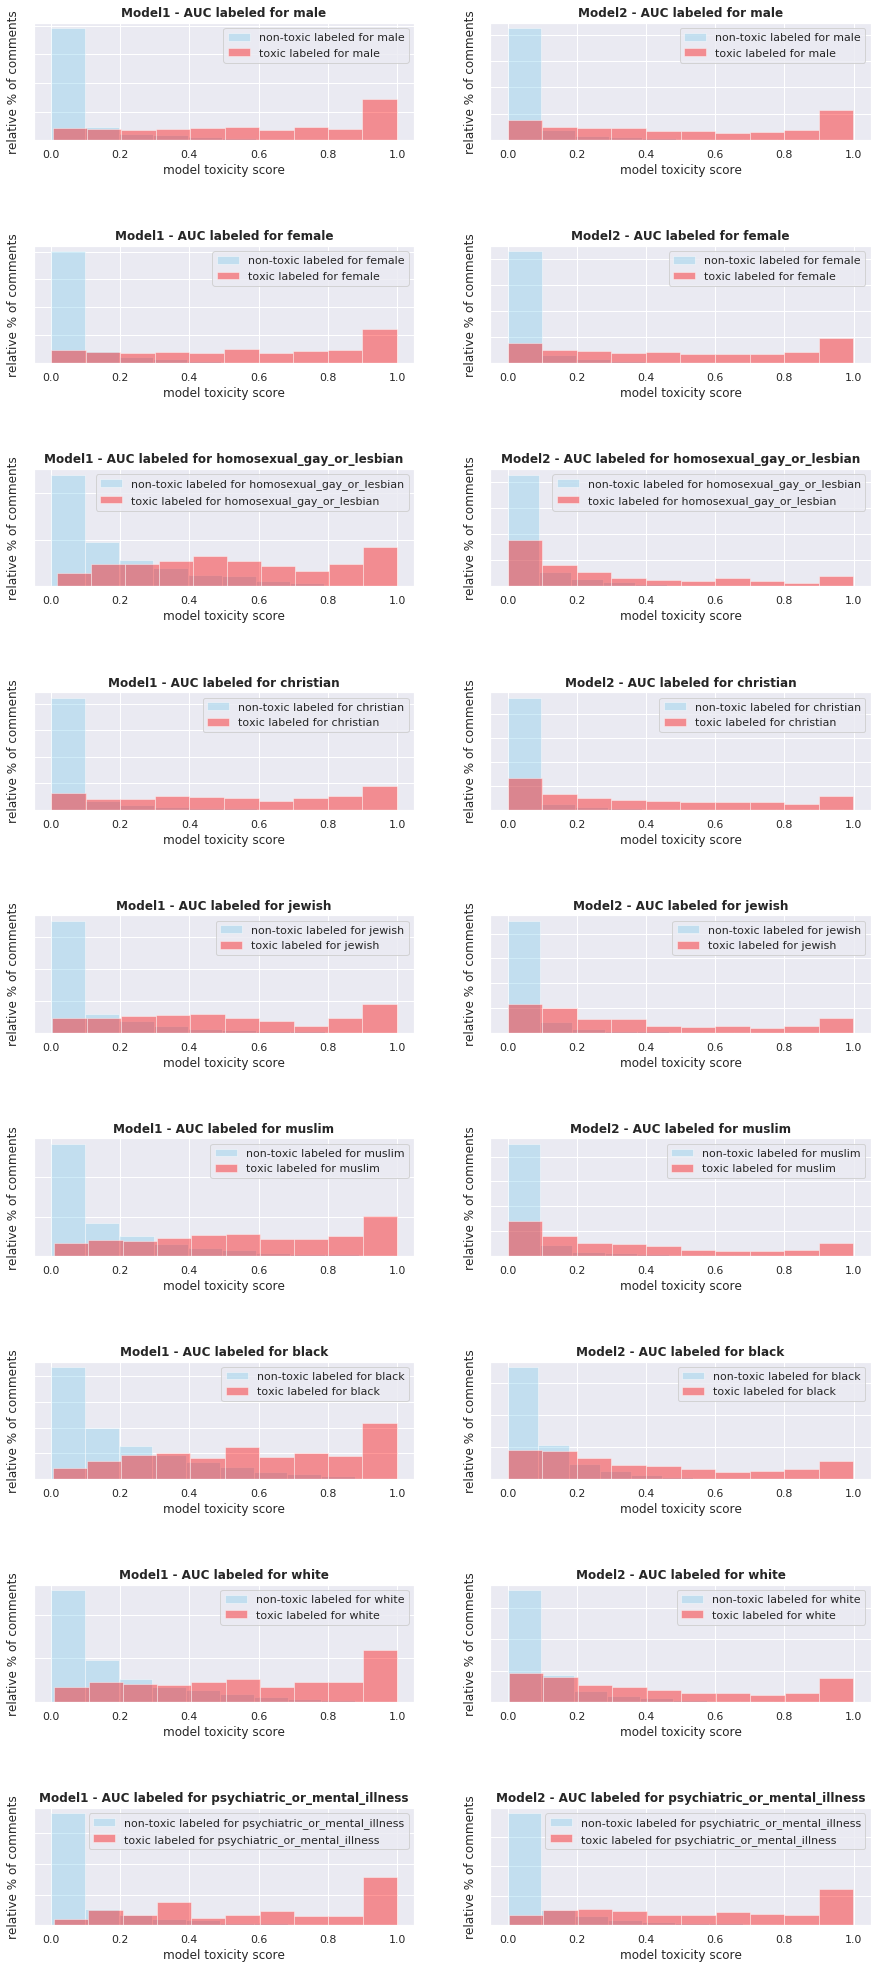

In [32]:
def plot_hist_subplot_9_2(df1, df2, identities, MODEL_NAME1, MODEL_NAME2):
  NUM_BINS=10     
  fig = plt.figure(figsize=(15, 35))
  fig.subplots_adjust(hspace=0.9, wspace=0.2)
  odd_columns = [1,3,5,7,9,11,13,15,17]
  even_columns = [2,4,6,8,10,12,14,16,18]
  for i in range(1,19): 
      if i in odd_columns:
        identity = identities[odd_columns.index(i)]       
        toxic_scores = df1.query(identity + ' == True & target == True')[MODEL_NAME1]
        non_toxic_scores = df1.query(identity + ' == True & target == False')[MODEL_NAME1]
        description = 'labeled for ' + identity
      
        ax = fig.add_subplot(9, 2, i)  
        sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False, ax=ax)
        sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False, ax=ax)
        ax.set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[])  
        ax.set_title(label='Model1 - AUC ' + description, fontweight="bold")
        plt.legend()
      else:
        identity = identities[even_columns.index(i)]       
        toxic_scores = df2.query(identity + ' == True & target == True')[MODEL_NAME2]
        non_toxic_scores = df2.query(identity + ' == True & target == False')[MODEL_NAME2]
        description = 'labeled for ' + identity
      
        ax = fig.add_subplot(9, 2, i)  
        sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False, ax=ax)
        sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False, ax=ax)
        ax.set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[])  
        ax.set_title(label='Model2 - AUC ' + description, fontweight="bold")
        plt.legend()
        
  #ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)        
  #plt.figure()  
  #plt.savefig('/content/drive/My Drive/Jigsaw/BERT_data/9_histos2.png', bbox_inches='tight')
  fig.savefig('/content/drive/My Drive/Jigsaw/BERT_data/9_histos3.png')



plot_hist_subplot_9_2(data, data_unbiased, [ 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness'], 'Model1', 'Model2' )

# Model 1

In [22]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

calculate_overall_auc(data, 'Model1')

0.9707347380721698

In [23]:
identity_columns = [ 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
MODEL_NAME = 'Model1'
bias_metrics_model1 = compute_bias_metrics_for_model(data, identity_columns, MODEL_NAME, 'target')
bias_metrics_model1

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.973520,0.865287,homosexual_gay_or_lesbian,0.861241,2223
6,0.977162,0.852540,black,0.866685,2959
7,0.974166,0.872112,white,0.871132,5003
5,0.974514,0.886042,muslim,0.891403,4229
4,0.963849,0.917871,jewish,0.894548,1529
8,0.974673,0.920425,psychiatric_or_mental_illness,0.927586,978
1,0.969774,0.941558,female,0.936922,10690
3,0.959565,0.955619,christian,0.936925,8285
0,0.973274,0.936044,male,0.937928,8894


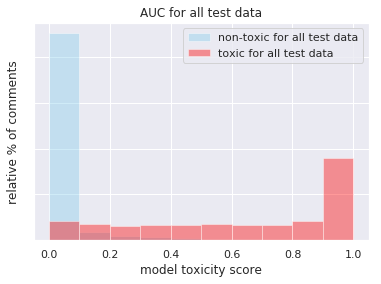

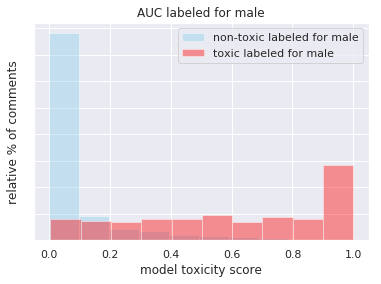

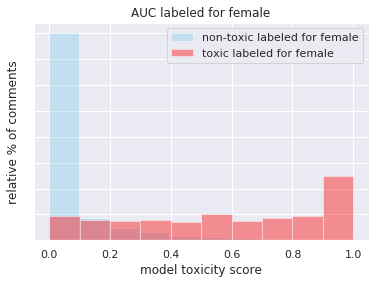

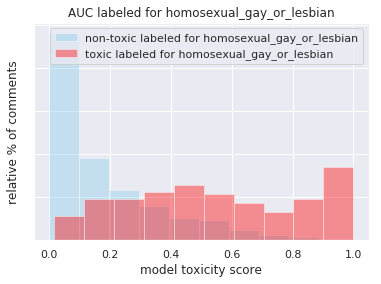

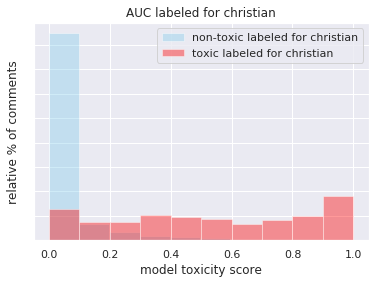

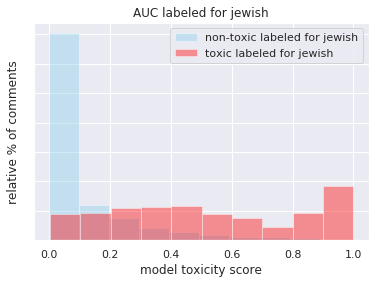

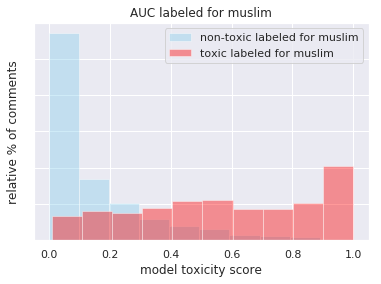

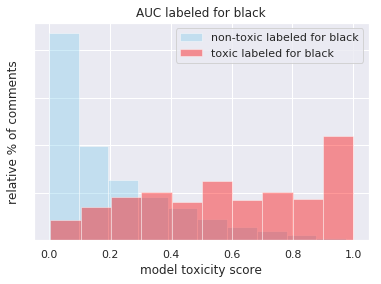

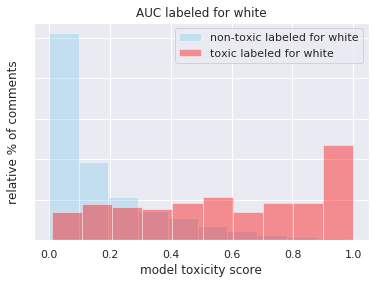

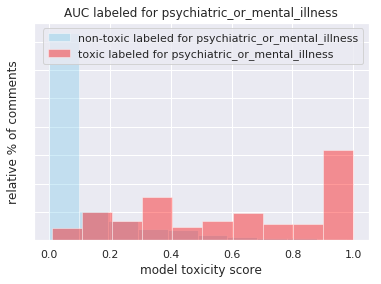

<Figure size 432x288 with 0 Axes>

In [25]:

MODEL_NAME = 'Model1'
# Plot the histogram for the background data, and for a few identities
plot_background_histogram(data)
for i in identity_columns:
   plot_histogram_for_identity(data, i)

# Model 2

In [26]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

calculate_overall_auc(data_unbiased, 'Model2')

0.9730347852862815

In [27]:
identity_columns = [ 'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
MODEL_NAME = 'model1'
bias_metrics_model2 = compute_bias_metrics_for_model(data_unbiased, identity_columns, 'Model2', 'target')
bias_metrics_model2

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.926592,0.943587,homosexual_gay_or_lesbian,0.817272,2223
6,0.955262,0.913229,black,0.837071,2959
7,0.957589,0.917519,white,0.850546,5003
5,0.937977,0.952694,muslim,0.869917,4229
4,0.943024,0.952243,jewish,0.891394,1529
8,0.973476,0.920057,psychiatric_or_mental_illness,0.918009,978
0,0.962567,0.948786,male,0.924274,8894
1,0.960163,0.953521,female,0.927235,10690
3,0.935395,0.973217,christian,0.927635,8285


In [28]:
data_unbiased.shape

(360975, 52)